In [74]:
# -*- coding: utf-8 -*-
# Python 3.12.6

# Internal Libs
import random
import os
from datetime import datetime
now = datetime.now()

# External Libs
import numpy as np
import pandas as pd
## Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Produced Libs:
## Data loader
from scripts.data_loader import DataLoader

## Filters
### Filters for AIS data
from scripts.filters.ais_filters import AISFilters as af, AISInterpolation as ai
### Filters for Norsat data
from scripts.filters.norsat_filters import NorsatFilters as nf
### Filters for SAR data
from scripts.filters.sar_filters import SARFilters as sf
### Filters for matched data
from scripts.filters.matched_filters import MatchedFilters as mf

## Matching algorithms
### Nearest neighbour
from scripts.matchers.nearest_neighbour_matching import NearestNeighbourMatcher as nnm
### Hungarian method
from scripts.matchers.hungarian_algorithm_matching import HungarianAlgorithmMatcher as ham
### Clustering methods
from scripts.matchers.clustering_matching import ClusteringMatcher as cma

## Plotting and understanding
### visualize uncertainty
from scripts.plots.difference_visualizer import DifferenceVisualizer as dv
### Map plotting
#from scripts.plots.map_plots import MapPlots as mp
### Cluster plotting
from scripts.plots.cluster_plot import ClusterPlot as cp

#from scripts.data_formatter import DataProcessor as dp
#from scripts.matching import hungarian_method
#from scripts.plotter import Plotter as pl

In [75]:
# Define date and time filter
date_key = '03-11-2022'

# PATHS, dataframe and shpfile #
# Define paths
base_path = "C:\\Users\\abelt\\OneDrive\\Desktop\\Kandidat\\"
## File names ##
# AIS
ais_files = {
    '02-11-2022': 'ais\\ais_110215.csv',
    '03-11-2022': 'ais\\ais_110315.csv',
    '05-11-2022': 'ais\\ais_1105.csv'
}
# SAR
sar_files = {
    '02-11-2022': 'sar\\Sentinel_1_detection_20221102T1519.json',
    '03-11-2022': 'sar\\Sentinel_1_detection_20221103T154515.json',
    '05-11-2022': 'sar\\Sentinel_1_detection_20221105T162459.json'
}
# Norsat
norsat_files = {
    '02-11-2022': 'norsat\\Norsat3-N1-JSON-Message-DK-2022-11-02T151459Z.json',
    '03-11-2022': 'norsat\\Norsat3-N1-JSON-Message-DK-2022-11-03T152759Z.json',
    '05-11-2022': 'norsat\\Norsat3-N1-JSON-Message-DK-2022-11-05T155259Z.json'
}

In [76]:
# Define date and time filter
date_key = '03-11-2022'

# PATHS, dataframe and shpfile #
# Define paths
base_path = "C:\\Users\\abelt\\OneDrive\\Desktop\\Kandidat\\"
## File names ##
# AIS
ais_files = {
    '02-11-2022': 'ais\\ais_110215.csv',
    '03-11-2022': 'ais\\ais_110315.csv',
    '05-11-2022': 'ais\\ais_1105.csv'
}
# SAR
sar_files = {
    '02-11-2022': 'sar\\Sentinel_1_detection_20221102T1519.json',
    '03-11-2022': 'sar\\Sentinel_1_detection_20221103T154515.json',
    '05-11-2022': 'sar\\Sentinel_1_detection_20221105T162459.json'
}
# Norsat
norsat_files = {
    '02-11-2022': 'norsat\\Norsat3-N1-JSON-Message-DK-2022-11-02T151459Z.json',
    '03-11-2022': 'norsat\\Norsat3-N1-JSON-Message-DK-2022-11-03T152759Z.json',
    '05-11-2022': 'norsat\\Norsat3-N1-JSON-Message-DK-2022-11-05T155259Z.json'
}

# LOADING #
data_loader = DataLoader(base_path = base_path, ais_files = ais_files, sar_files = sar_files, norsat_files = norsat_files, date_key = date_key)
ais_loader, sar_loader, norsat_loader = data_loader.load_data()

######### SAR #########
# images by date_key: sar_loader.dfs_sar
# objects by date_key: sar_loader.sar_object_dfs
######### AIS #########
#ais_loader.dfs_ais
######### Norsat #########
#norsat_loader.dfs_norsat

sar_data = sar_loader.sar_object_dfs[date_key].copy()
ais_data = ais_loader.dfs_ais[date_key].copy()
norsat_data = norsat_loader.dfs_norsat[date_key].copy()

AIS Data Loaded:
dict_keys(['02-11-2022', '03-11-2022', '05-11-2022'])
Columns for the first DataFrame: Index(['ais_id', 'mmsi', 'TimeStamp', 'latitude', 'longitude', 'length',
       'width', 'sog', 'cog', 'source'],
      dtype='object')
Norsat Data Loaded:
dict_keys(['02-11-2022', '03-11-2022', '05-11-2022'])
Columns for the first DataFrame: Index(['norsat_id', 'TimeStamp', 'latitude', 'longitude',
       'CollectionInformation', 'NRDEmitterPosition', 'CandidateList',
       'source', 'UncertaintyEllipsePoints'],
      dtype='object')
SAR Data Loaded:
dict_keys(['02-11-2022', '03-11-2022', '05-11-2022'])
Columns for the first DataFrame: Index(['ProductType', 'Polarization', 'Swath', 'TimeStamp', 'TimeStamp_end',
       'Name', 'Satellite', 'Shape', 'Objects', 'source'],
      dtype='object')
SAR object Loaded:
dict_keys(['02-11-2022', '03-11-2022', '05-11-2022'])
Columns for the first DataFrame: Index(['sar_id', 'sar_image_id', 'TimeStamp', 'latitude', 'longitude', 'width',
       '

Use an MLP to create a cost matrix. The data loader should be a 


In [77]:
# FILTERING #
# Filter SAR data
## Filter out SAR data based on on_sea
sar_data = sar_data[sar_data['on_sea'] == True] # This is the SAR data that is on sea
## Filter out SAR data based on class 0
filtered_sar_data = sf.filter_sar_probabilities(sar_data) # This is the SAR data that is class 0

# Filter AIS data
## Define the time threshold for comparison
delta_time = pd.Timedelta(hours=1)
## Finding vessels in AIS data that are close to objects in SAR and Norsat
mmsi_ais_sar = af.ais_find_matching_vessels(AIS_data=ais_data, comparison_data=sar_data, delta_time=delta_time) # This is the AIS data that is close to SAR data time
mmsi_ais_norsat = af.ais_find_matching_vessels(AIS_data=ais_data, comparison_data=norsat_data, delta_time=delta_time) # This is the AIS data that is close to Norsat data time
## Filter AIS data by MMSI
filtered_ais_to_sar = af.filter_by_mmsi(mmsi_ais_sar, ais_data) # This is the AIS data by MMSI numbers that are close to SAR data
filtered_ais_to_norsat = af.filter_by_mmsi(mmsi_ais_norsat, ais_data) # This is the AIS data by MMSI numbers that are close to Norsat data

In [78]:
# INTERPOLATION WITH FILTERING #
# Interpolate MMSI points for filtered AIS data to SAR and Norsat
print('Interpolating MMSI points for filtered AIS data to:')
## Interpolate MMSI points for filtered AIS data to SAR
print('SAR')
interpolated_ais_sar, not_enough_sar = ai.ais_interpolate_mmsi_points(filtered_ais_to_sar, sar_data['TimeStamp'])
## Interpolate MMSI points for filtered AIS data to Norsat
print('Norsat')
interpolated_ais_norsat, not_enough_norsat = ai.ais_interpolate_mmsi_points(filtered_ais_to_norsat, norsat_data['TimeStamp'])

# Evaluate the speed over ground between interpolation point and before/after points
## AIS to SAR interpolation dataframe
interpolated_ais_sar = ai.evaluate_sog_between_points(interpolated_ais_sar, 35)
## AIS to Norsat interpolation dataframe
interpolated_ais_norsat = ai.evaluate_sog_between_points(interpolated_ais_norsat, 35)

## Filter out AIS data that has a speed over ground of > 35 knots
### AIS to SAR interpolation dataframe
interpolated_ais_sar = interpolated_ais_sar[
    ~interpolated_ais_sar['exceeds_threshold_before'] & 
    ~interpolated_ais_sar['exceeds_threshold_after']]
### AIS to Norsat interpolation dataframe
interpolated_ais_norsat = interpolated_ais_norsat[
    ~interpolated_ais_norsat['exceeds_threshold_before'] & 
    ~interpolated_ais_norsat['exceeds_threshold_after']]
print('Speed over ground filtering, (SOG > 35 knots):')
print('MMSI numbers with AIS data that do not exceed the SOG threshold for SAR:', len(interpolated_ais_sar.groupby('mmsi')))
print('MMSI numbers with AIS data that do not exceed the SOG threshold for Norsat:', len(interpolated_ais_norsat.groupby('mmsi')))

Interpolating MMSI points for filtered AIS data to:
SAR
MMSI numbers with insufficient data points: 99 out of 2515
Norsat
MMSI numbers with insufficient data points: 98 out of 2520
Speed over ground filtering, (SOG > 35 knots):
MMSI numbers with AIS data that do not exceed the SOG threshold for SAR: 2404
MMSI numbers with AIS data that do not exceed the SOG threshold for Norsat: 2406


In [79]:
## Non clustered matching ##
# NEAREST NEIGHBOUR MATCHING #
nnm_ais_sar = nnm.nearest_neighbour_matching(df1 = interpolated_ais_sar, df2 = filtered_sar_data, id1_col = 'mmsi', id2_col = 'sar_id')
nnm_ais_norsat = nnm.nearest_neighbour_matching(df1 = interpolated_ais_norsat, df2 = norsat_data, id1_col = 'mmsi', id2_col = 'norsat_id')
nnm_sar_norsat = nnm.nearest_neighbour_matching(df1 = filtered_sar_data, df2 = norsat_data, id1_col = 'sar_id', id2_col = 'norsat_id')
NNM = {'ais_sar': nnm_ais_sar, 'ais_norsat': nnm_ais_norsat, 'sar_norsat': nnm_sar_norsat}

# HUNGARIAN METHOD MATCHING #
ham_ais_sar, ais_sar_cost_matrix = ham.hungarian_method_matching(df1 = interpolated_ais_sar, df2 = filtered_sar_data, id1_col = "mmsi", id2_col = "sar_id")
ham_ais_norsat, ais_norsat_cost_matrix = ham.hungarian_method_matching(df1 = interpolated_ais_norsat, df2 = norsat_data,  id1_col = "mmsi", id2_col = "norsat_id")
ham_sar_norsat, sar_norsat_cost_matrix = ham.hungarian_method_matching(df1 = filtered_sar_data, df2 = norsat_data,  id1_col = "sar_id", id2_col = "norsat_id")
HAM = {'ais_sar': ham_ais_sar, 'ais_norsat': ham_ais_norsat, 'sar_norsat': ham_sar_norsat}

In [80]:
## Clustering variables ##
epsilon = 7 # Epsilon for DBSCAN, UNIT: kilometers
min_samples = 2 # Minimum samples for DBSCAN
print('Clustering with epsilon:', epsilon, 'km \n Minimum samples:', min_samples)

Clustering with epsilon: 7 km 
 Minimum samples: 2


In [81]:
# HUNGARIAN METHOD WITH CLUSTERING #
CHAM_ais_sar = cma.HAM_clustering(df1 = interpolated_ais_sar, df2 = filtered_sar_data, ids=['mmsi', 'sar_id'], sources=['ais', 'sar'], eps=epsilon, min_samples=min_samples)
CHAM_ais_norsat = cma.HAM_clustering(df1 = interpolated_ais_norsat, df2 = norsat_data, ids=['mmsi', 'norsat_id'], sources=['ais', 'norsat'], eps=epsilon, min_samples=min_samples)
CHAM_sar_norsat = cma.HAM_clustering(df1 = filtered_sar_data, df2 = norsat_data, ids=['sar_id', 'norsat_id'], sources=['sar', 'norsat'], eps=epsilon, min_samples=min_samples)
CHAM = {'ais_sar': CHAM_ais_sar, 'ais_norsat': CHAM_ais_norsat, 'sar_norsat': CHAM_sar_norsat}

Estimated number of clusters: 241
Estimated number of noise points: 184
Estimated number of clusters: 235
Estimated number of noise points: 192
Estimated number of clusters: 67
Estimated number of noise points: 132


In [82]:
# NEAREST NEIGHBOUR WITH CLUSTERING #
CNNM_ais_sar = cma.NNM_clustering(df1 = interpolated_ais_sar, df2=filtered_sar_data, ids=['mmsi', 'sar_id'], sources=['ais', 'sar'], eps=epsilon, min_samples=min_samples)
CNNM_ais_norsat = cma.NNM_clustering(df1 = interpolated_ais_norsat, df2 = norsat_data, ids=['mmsi', 'norsat_id'], sources=['ais', 'norsat'], eps=epsilon, min_samples=min_samples)
CNNM_sar_norsat = cma.NNM_clustering(df1 = filtered_sar_data, df2 = norsat_data, ids=['sar_id', 'norsat_id'], sources=['sar', 'norsat'], eps=epsilon, min_samples=min_samples)
CNNM = {'ais_sar':CNNM_ais_sar, 'ais_norsat':CNNM_ais_norsat, 'sar_norsat':CNNM_sar_norsat}

Estimated number of clusters: 241
Estimated number of noise points: 184
Estimated number of clusters: 235
Estimated number of noise points: 192
Estimated number of clusters: 67
Estimated number of noise points: 132


In [83]:
# SORTING and DISTANCE THRESHOLDING #
ais_sar = {'nnm': NNM['ais_sar'], 'ham': HAM['ais_sar'], 'cnnm': CNNM['ais_sar'], 'cham': CHAM['ais_sar']}
ais_norsat = {'nnm': NNM['ais_norsat'], 'ham': HAM['ais_norsat'], 'cnnm': CNNM['ais_norsat'], 'cham': CHAM['ais_norsat']}
sar_norsat = {'nnm': NNM['sar_norsat'], 'ham': HAM['sar_norsat'], 'cnnm': CNNM['sar_norsat'], 'cham': CHAM['sar_norsat']}

# Thresholding by distance
d_threshold = 15 #km
thresholded_ais_sar = mf.filter_by_distance(ais_sar, distance_threshold = d_threshold, printer=False)
thresholded_ais_norsat = mf.filter_by_distance(ais_norsat, distance_threshold = d_threshold, printer=False)
thresholded_sar_norsat = mf.filter_by_distance(sar_norsat, distance_threshold = d_threshold, printer=False)

In [84]:
# Cluster and plot #
# clustered_df = cp.apply_dbscan_clustering(interpolated_ais_sar, filtered_sar_data, ids=['mmsi', 'sar_id'], sources=['ais', 'sar'], eps=7, min_samples=2)
# Plot the resulting clusters
# cp.plot_clusters(clustered_df, title="DBSCAN Clustering of Combined DataFrames")

In [85]:
thresholded_ais_sar
thresholded_ais_norsat
thresholded_sar_norsat

{'nnm':      sar_id    df1_lat    df1_lon  norsat_id    df2_lat    df2_lon  \
 360   20607  69.876061  18.249585        123  69.876180  18.251560   
 370   20621  70.308222  20.916549         85  70.310265  20.913460   
 430   20997  70.539330  19.724481         95  70.536050  19.724018   
 437   21072  70.006838  20.263113         67  70.008580  20.252964   
 386   20651  70.097503  20.260136         75  70.097470  20.276854   
 358   20605  70.549009  19.718289        115  70.549320  19.697020   
 352   20598  70.175504  21.069091         96  70.186134  21.085976   
 394   20668  69.882050  18.422302         57  69.894165  18.400429   
 332   18907  69.336192  19.367237        139  69.339040  19.327263   
 344   19065  69.240538  19.377068         99  69.255710  19.365046   
 378   20634  70.117452  20.225707        127  70.099236  20.196861   
 356   20603  69.970377  19.687403        107  69.967990  19.625044   
 366   20616  70.615824  19.036156        155  70.627620  18.981178   

In [86]:
#print('AIS - SAR')
#dv.dataframe_comparisons(thresholded_ais_sar, 'mmsi', 'sar_id')

#print('AIS - Norsat')
#dataframe_comparisons(ais_norsat, 'mmsi', 'norsat_id')

# print('SAR - Norsat')
# dataframe_comparisons(sar_norsat, 'sar_id', 'norsat_id')

In [87]:
thresholded_ais_sar['cnnm']
thresholded_ais_norsat['cnnm']
thresholded_sar_norsat['cnnm']
# Triple matchings
triple_match_df = thresholded_ais_sar['cnnm'].merge(thresholded_ais_norsat['cnnm'], on=['mmsi'])
triple_match_df

,mmsi,df1_lat_x,df1_lon_x,sar_id,df2_lat_x,df2_lon_x,distance_km_x,cluster_x,df1_lat_y,df1_lon_y,norsat_id,df2_lat_y,df2_lon_y,distance_km_y,cluster_y
0,258791000,70.117191,21.003418,20619,70.118301,21.001138,0.150592,9,70.154700,21.050642,96,70.186134,21.085976,3.740825,8
1,257602000,70.306731,20.915603,20621,70.308222,20.916549,0.169572,9,70.304742,20.913151,85,70.310265,20.913460,0.614195,8
2,215489000,70.555154,17.219986,20602,70.555498,17.202062,0.664587,10,70.583238,17.308607,101,70.617240,17.404491,5.180403,9
3,218066000,70.616123,19.026352,20616,70.615824,19.036156,0.363368,11,70.619901,18.973936,155,70.627620,18.981178,0.898911,10
4,273298600,70.609640,19.199160,21123,70.613435,19.197632,0.425738,11,70.595816,19.157787,47,70.598460,19.080280,2.878173,10
5,257080750,69.883005,18.411341,20668,69.882050,18.422302,0.432476,16,69.873855,18.291648,123,69.876180,18.251560,1.555335,113
6,257215500,69.970244,19.674281,20603,69.970377,19.687403,0.499955,17,69.966682,19.641001,107,69.967990,19.625044,0.624966,16
7,257913000,70.538337,19.725758,20997,70.539330,19.724481,0.120153,39,70.535988,19.719234,95,70.536050,19.724018,0.177392,143
8,259617000,70.096069,20.261216,20651,70.097503,20.260136,0.164622,64,70.095663,20.281527,75,70.097470,20.276854,0.267686,63
9,257459500,70.004939,20.259861,21072,70.006838,20.263113,0.244661,64,70.003912,20.257460,67,70.008580,20.252964,0.546429,63


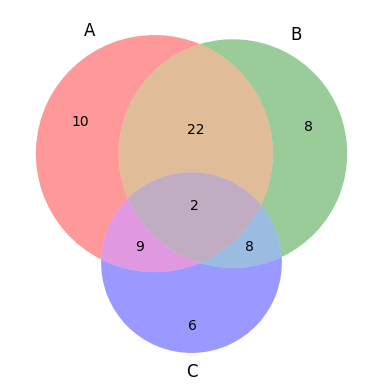

In [88]:
# Import the library
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
 
# Make the diagram
venn3(subsets = (10, 8, 22, 6,9,8,2))
plt.show()

I need a function that matches the three dataframes based on three speficied id column. Then outputs a venn diagram

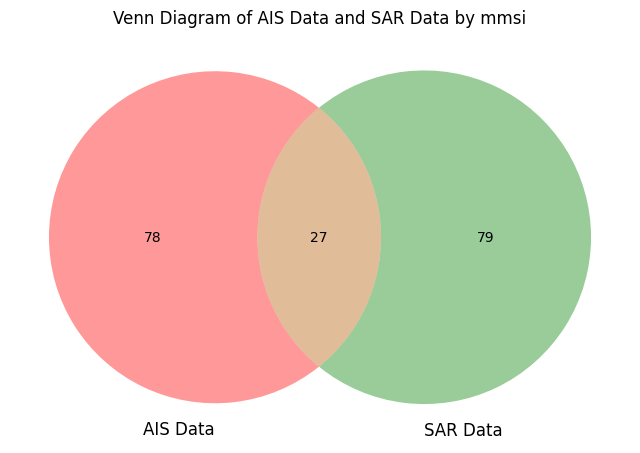

In [89]:
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

def match_dataframes_and_venn(df1, df2, id_column, df1_label='DF1', df2_label='DF2'):
    """
    Matches two dataframes based on a specific id column and outputs a Venn diagram.
    
    Parameters:
    - df1: First dataframe
    - df2: Second dataframe
    - id_column: The name of the ID column to match on
    - df1_label: Label for the first dataframe in the Venn diagram
    - df2_label: Label for the second dataframe in the Venn diagram
    
    Returns:
    A Venn diagram showing the overlap of the two dataframes based on the id_column.
    """
    # Convert ID columns to sets for comparison
    set1 = set(df1[id_column])
    set2 = set(df2[id_column])
    
    # Create the Venn diagram
    plt.figure(figsize=(8, 8))
    venn2([set1, set2], set_labels=(df1_label, df2_label))
    
    # Show plot
    plt.title(f'Venn Diagram of {df1_label} and {df2_label} by {id_column}')
    plt.show()

# Example usage
# Assuming df1 and df2 are your dataframes and 'mmsi' is the ID column
match_dataframes_and_venn(ais_sar['cnnm'], ais_norsat['cnnm'], 'mmsi', 'AIS Data', 'SAR Data')


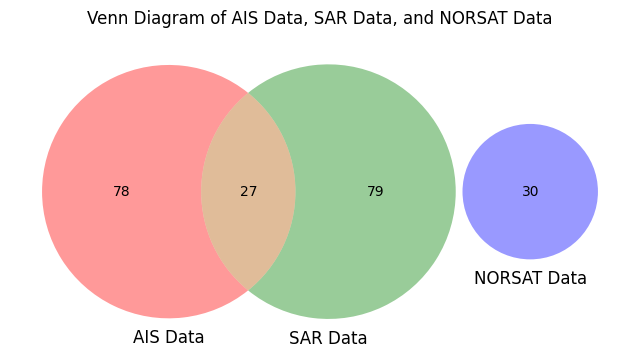

In [90]:
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

def match_three_dataframes_and_venn(df1, df2, df3, id_column1, id_column2, id_column3, df1_label='DF1', df2_label='DF2', df3_label='DF3'):
    """
    Matches three dataframes based on three specific id columns and outputs a Venn diagram.
    
    Parameters:
    - df1: First dataframe
    - df2: Second dataframe
    - df3: Third dataframe
    - id_column1: The ID column to match on in df1
    - id_column2: The ID column to match on in df2
    - id_column3: The ID column to match on in df3
    - df1_label: Label for the first dataframe in the Venn diagram
    - df2_label: Label for the second dataframe in the Venn diagram
    - df3_label: Label for the third dataframe in the Venn diagram
    
    Returns:
    A Venn diagram showing the overlap of the three dataframes based on the id_columns.
    """
    # Convert ID columns to sets for comparison
    set1 = set(df1[id_column1])
    set2 = set(df2[id_column2])
    set3 = set(df3[id_column3])
    
    # Create the Venn diagram
    plt.figure(figsize=(8, 8))
    venn3([set1, set2, set3], set_labels=(df1_label, df2_label, df3_label))
    
    # Show plot
    plt.title(f'Venn Diagram of {df1_label}, {df2_label}, and {df3_label}')
    plt.show()

# Example usage
# Assuming df1, df2, and df3 are your dataframes, and 'mmsi' or other ID columns are what you match on
match_three_dataframes_and_venn(ais_sar['cnnm'], ais_norsat['cnnm'], sar_norsat['cnnm'], 'mmsi', 'mmsi', 'sar_id', 'AIS Data', 'SAR Data', 'NORSAT Data')


Set1 (AIS Data - mmsi): {258688000, 257003010, 230063110, 257068550, 257071110, 230985740, 257215500, 259004430, 265066000, 257327120, 257021970, 257834000, 257216020, 257223700, 276842000, 257248800, 230167080, 273377320, 257010730, 265022000, 258019890, 257125430, 257683000, 230980670, 257704000, 259009090, 230942790, 246845000, 257452620, 257639500, 265007180, 230942800, 257515600, 218066000, 266450000, 230070870, 258791000, 257852000, 257578600, 257898600, 636020331, 257124460, 246630000, 258470000, 259302000, 257731700, 265518710, 230352000, 230928000, 265626250, 257185420, 258874000, 257892500, 992576153, 992576154, 992576155, 257432220, 992576156, 992576157, 992576158, 236644000, 230065310, 992576165, 273298600, 257913000, 257168040, 257056440, 259107000, 259683000, 992576196, 992576198, 212621000, 257677000, 232866000, 230990040, 257676000, 259617000, 255806187, 257150700, 257120500, 212491000, 230667000, 257093370, 941500155, 230140160, 250165000, 230109450, 257137420, 2096100

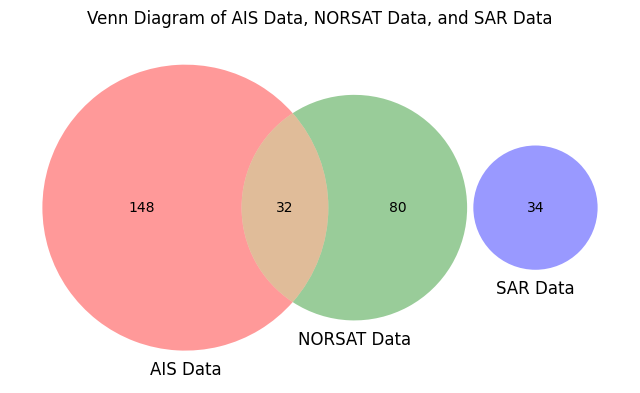

In [91]:
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

def match_three_dataframes_and_venn(df1, df2, df3, df1_id1, df1_id2, df2_id1, df2_id2, df3_id1, df3_id2, df1_label='DF1', df2_label='DF2', df3_label='DF3'):
    """
    Matches three dataframes based on specific id columns and outputs a Venn diagram.
    
    Parameters:
    - df1: First dataframe (contains df1_id1 and df1_id2)
    - df2: Second dataframe (contains df2_id1 and df2_id2)
    - df3: Third dataframe (contains df3_id1 and df3_id2)
    - df1_id1: ID column in df1 to match with df2 (e.g. 'mmsi')
    - df1_id2: ID column in df1 to match with df3 (e.g. 'sar_id')
    - df2_id1: ID column in df2 to match with df1 (e.g. 'mmsi')
    - df2_id2: ID column in df2 to match with df3 (e.g. 'norsat_id')
    - df3_id1: ID column in df3 to match with df1 (e.g. 'sar_id')
    - df3_id2: ID column in df3 to match with df2 (e.g. 'norsat_id')
    - df1_label: Label for the first dataframe in the Venn diagram
    - df2_label: Label for the second dataframe in the Venn diagram
    - df3_label: Label for the third dataframe in the Venn diagram
    
    Returns:
    A Venn diagram showing the overlap of the three dataframes based on the id_columns.
    """
    # Convert ID columns to sets for comparison
    set1 = set(df1[df1_id1])  # mmsi from df1
    set2 = set(df2[df2_id1])  # mmsi from df2
    set3 = set(df3[df3_id1])  # sar_id from df3
    
    # Debug the sets before plotting
    print(f"Set1 (AIS Data - mmsi): {set1}")
    print(f"Set2 (NORSAT Data - mmsi): {set2}")
    print(f"Set3 (SAR Data - sar_id): {set3}")

    print("Intersection between AIS and NORSAT:", set1 & set2)
    print("Intersection between AIS and SAR:", set1 & set3)
    print("Intersection between NORSAT and SAR:", set2 & set3)
    # Create the Venn diagram
    plt.figure(figsize=(8, 8))
    venn3([set1, set2, set3], set_labels=(df1_label, df2_label, df3_label))
    
    # Show plot
    plt.title(f'Venn Diagram of {df1_label}, {df2_label}, and {df3_label}')
    plt.show()

# Example usage:
# Assuming df1 contains 'mmsi' and 'sar_id', df2 contains 'mmsi' and 'norsat_id', and df3 contains 'sar_id' and 'norsat_id'
match_three_dataframes_and_venn(
    ais_sar['cham'], ais_norsat['cham'], sar_norsat['cham'], 
    'mmsi', 'sar_id',  # df1: match mmsi with df2 and sar_id with df3
    'mmsi', 'norsat_id',  # df2: match mmsi with df1 and norsat_id with df3
    'sar_id', 'norsat_id',  # df3: match sar_id with df1 and norsat_id with df2
    df1_label='AIS Data', df2_label='NORSAT Data', df3_label='SAR Data'
)

In [92]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

def create_venn_using_merge(dfs : list[pd.DataFrame], model : str, id_columns : list[str], labels : list[str]):

    ais_sar = dfs[0][model].copy()
    ais_norsat = dfs[1][model].copy()
    sar_norsat = dfs[2][model].copy()

    # Match AIS-SAR with SAR-NORSAT through 'sar_id'
    ais_sar_sar_norsat_merge = ais_sar.merge(sar_norsat, on=['sar_id'])
    ais_sar_sar_norsat_count = len(ais_sar_sar_norsat_merge)

    # Match AIS-SAR-SAR-NORSAT with AIS-NORSAT through 'mmsi' and 'norsat_id'
    full_match_merge = ais_sar_sar_norsat_merge.merge(ais_norsat, on=['mmsi', 'norsat_id'])
    full_match_count = len(full_match_merge)

    # Match AIS-NORSAT with SAR-NORSAT through 'norsat_id'
    ais_norsat_sar_norsat_merge = ais_norsat.merge(sar_norsat, on=['norsat_id'])
    ais_norsat_sar_norsat_count = len(ais_norsat_sar_norsat_merge)

    # Match AIS-NORSAT-SAR-NORSAT with AIS-SAR through 'mmsi' and 'sar_id'
    reverse_full_match_merge = ais_norsat_sar_norsat_merge.merge(ais_sar, on=['mmsi', 'sar_id'])
    reverse_full_match_count = len(reverse_full_match_merge)

    # Find unique counts for each set
    ais_count = len(ais_sar)  # AIS-SAR matches
    norsat_count = len(ais_norsat)  # AIS-NORSAT matches
    sar_count = len(sar_norsat)  # SAR-NORSAT matches

    # Now calculate the overlaps
    only_ais = ais_count - ais_sar_sar_norsat_count  # AIS-SAR only
    only_norsat = norsat_count - ais_norsat_sar_norsat_count  # AIS-NORSAT only
    only_sar = sar_count - ais_sar_sar_norsat_count  # SAR-NORSAT only
    ais_norsat_overlap = ais_norsat_sar_norsat_count - full_match_count  # AIS-NORSAT overlap
    ais_sar_overlap = ais_sar_sar_norsat_count - full_match_count  # AIS-SAR overlap
    sar_norsat_overlap = ais_norsat_sar_norsat_count - full_match_count  # SAR-NORSAT overlap
    full_overlap = full_match_count  # Full overlap (all three)

    # Create the Venn diagram
    plt.figure(figsize=(8, 8))
    venn = venn3(subsets=(only_ais, only_norsat, ais_norsat_overlap,
                          only_sar, ais_sar_overlap, sar_norsat_overlap, full_overlap),
                 set_labels=('AIS-SAR', 'AIS-NORSAT', 'SAR-NORSAT'))
    
    # Show the Venn diagram
    plt.title('Venn Diagram of AIS-SAR, AIS-NORSAT, and SAR-NORSAT Data')
    plt.show()

In [93]:
create_venn_using_merge(ais_sar['cham'], ais_norsat['cham'], sar_norsat['cham'])

TypeError: create_venn_using_merge() missing 1 required positional argument: 'labels'

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import pandas as pd

def create_venn_using_merge(dfs: list[pd.DataFrame], model: str, id_columns: list[str], labels: list[str]):
    """
    Generalized function to create a Venn diagram from multiple dataframes based on specified ID columns.
    
    Parameters:
    - dfs: List of dataframes (assumed to be AIS-SAR, AIS-NORSAT, SAR-NORSAT in that order).
    - model: The key to access the relevant part of each dataframe (e.g., 'cham').
    - id_columns: List containing the IDs to use for merging (in the same order as the dataframes).
      Example: ['mmsi', 'sar_id', 'norsat_id']
    - labels: Labels for the datasets in the Venn diagram (e.g., ['AIS-SAR', 'AIS-NORSAT', 'SAR-NORSAT']).
    
    Returns:
    - Venn diagram showing the overlaps between the datasets based on the specified columns.
    """
    
    # Extract dataframes based on model
    ais_sar = dfs[0][model].copy()  # First dataframe (AIS-SAR)
    ais_norsat = dfs[1][model].copy()  # Second dataframe (AIS-NORSAT)
    sar_norsat = dfs[2][model].copy()  # Third dataframe (SAR-NORSAT)

    # Merge AIS-SAR with SAR-NORSAT based on the second ID (sar_id)
    ais_sar_sar_norsat_merge = ais_sar.merge(sar_norsat, on=[id_columns[1]])
    ais_sar_sar_norsat_count = len(ais_sar_sar_norsat_merge)

    # Merge AIS-SAR-SAR-NORSAT with AIS-NORSAT based on the first (mmsi) and third IDs (norsat_id)
    full_match_merge = ais_sar_sar_norsat_merge.merge(ais_norsat, on=[id_columns[0], id_columns[2]])
    full_match_count = len(full_match_merge)

    # Merge AIS-NORSAT with SAR-NORSAT based on the third ID (norsat_id)
    ais_norsat_sar_norsat_merge = ais_norsat.merge(sar_norsat, on=[id_columns[2]])
    ais_norsat_sar_norsat_count = len(ais_norsat_sar_norsat_merge)

    # Find unique counts for each set
    ais_count = len(ais_sar)  # AIS-SAR matches
    norsat_count = len(ais_norsat)  # AIS-NORSAT matches
    sar_count = len(sar_norsat)  # SAR-NORSAT matches

    # Calculate overlaps
    only_ais = ais_count - ais_sar_sar_norsat_count  # AIS-SAR only
    only_norsat = norsat_count - ais_norsat_sar_norsat_count  # AIS-NORSAT only
    only_sar = sar_count - ais_sar_sar_norsat_count  # SAR-NORSAT only
    ais_norsat_overlap = ais_norsat_sar_norsat_count - full_match_count  # AIS-NORSAT overlap
    ais_sar_overlap = ais_sar_sar_norsat_count - full_match_count  # AIS-SAR overlap
    sar_norsat_overlap = ais_norsat_sar_norsat_count - full_match_count  # SAR-NORSAT overlap
    full_overlap = full_match_count  # Full overlap (all three)

    # Create the Venn diagram
    plt.figure(figsize=(8, 8))
    venn3(subsets=(only_ais, only_norsat, ais_norsat_overlap,
                   only_sar, ais_sar_overlap, sar_norsat_overlap, full_overlap),
          set_labels=(labels[0], labels[1], labels[2]))

    # Show the Venn diagram
    plt.title(f'Venn Diagram of {labels[0]}, {labels[1]}, and {labels[2]} matches')
    plt.show()

# Example usage:
dfs = [ais_sar,ais_norsat,sar_norsat]
model = 'cnnm'
id_columns = ['mmsi', 'sar_id', 'norsat_id']
labels = ['AIS-SAR', 'AIS-NORSAT', 'SAR-NORSAT']
create_venn_using_merge(dfs, model, id_columns, labels)


# TO-DO
- Triple matching function, through AIS mmsi numbers.
    - triple_match_df = sar_df.merge(norsat_df, on=['mmsi'])
    
- Venn diagram
    - By data types.
    - By matching models, for individual data types.

- Generate Map plots: <br>
    "f"MMSI: {mmsi_number_row}<br>{df1_index_column}: {index_row}<br>Distance: {distance_row}
    <br>Matching:"
    - SAR & AIS
    - SAR & RF
    - AIS & RF
    - SAR, AIS, & RF

- Create uncertainty chart or correlation value chart
    - Colorbar based on the angle of the uncertainty ellipse for a uncertainty plot

- Create a "true" matches dataset
- Assume a one data type to be a reference point

# Notes:
- Beskriv med "egen fornuft" fejlkilder, for at begynder og overveje hvordan de kan mitigeres, fjernes eller accepteres.
- Real sar opløsning 22 meter, men oversampler for til 10x10